In [244]:
250306

250306

In [245]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Callable

# Lab 9 - Multi-layer Perceptron Forward Pass & Backpropagation

## Part I
For this exercise you will implement a simple 2-layer perceptron with the forward pass and the backpropagation to learn the weights

For the first part you'll build and train a 2-layer neural network that predicts the prices of houses, using the usual Boston housing dataset.

In [246]:
boston = pd.read_csv('data/housing.csv')

As usual, consider the MEDV as your target variable. 
* Split the data into training, validation and testing (70,15,15)%
* Experiment with different number of neurons per layer for your network, using the validation set

In [247]:
t = boston['MEDV']
boston = boston.drop(['MEDV'], axis=1)

X_train, X_to_split, t_train, t_to_split = train_test_split(boston, t, train_size=.7)
X_validation, X_test, t_validation, t_test = train_test_split(X_to_split, t_to_split, train_size=.5)

X_train = X_train.to_numpy()
X_validation = X_validation.to_numpy()
X_test = X_test.to_numpy()

t_train = t_train.to_numpy()
t_validation = t_validation.to_numpy()
t_test = t_test.to_numpy()

In [248]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    """Sigmoid Function

    Args:
        z (np.ndarray | pd.Series): The vector that we'll apply the sigmoid function
    """
    return 1 / (1 + np.exp(-z))


def d_sigmoid(x: np.ndarray) -> np.ndarray:
    """Sigmoid Derivate Function

    Args:
        z (np.ndarray | pd.Series): Vector that will have the sigmoid applied

    Returns:
        np.ndarray: Derivative applied
    """
    return sigmoid(x) * (1 - sigmoid(x))


def root_mean_squared_error(y: np.ndarray, t: np.ndarray) -> float:
    """Function for calculating the RMSE

    Args:
        x (np.ndarray): Vector for making the RMSE

    Returns:
        float: RMSE
    """
    x = y - t
    return np.sqrt(np.sum(x**2)/len(x))


In [266]:
class MultilayerPerceptron1Hidden:
    def __init__(self,
        activation: Callable[[np.ndarray], np.ndarray],
        d_activation: Callable[[np.ndarray], np.ndarray],
        error_function: Callable[[np.ndarray, np.ndarray], np.float64|float],
        D: int,
        M: int,
        K: int,
        output_function:Callable[[np.ndarray], np.ndarray]=lambda x: x
    ):
        """Implements the forward pass of a two-layer fully connected perceptron.

        Args:
            activation (Callable[[np.ndarray], np.ndarray]): The network's activation function
            d_activation (Callable[[np.ndarray], np.ndarray]): The network's activation function's derivative
            error_function (Callable[[np.ndarray, np.ndarray], np.float64 | float]): The error function: e.g Cross Entropy, SSE
            D (int): Neurons in the input layer
            M (int): Neurons in the hidden layer
            K (int): Neurons in the output layer
            output_function (Callable[[np.ndarray], np.ndarray], optional): Function applied to the final output. Defaults to lambdax:x (Identity).
        """
        self.activation = activation
        self.d_activation = d_activation
        self.error_function = error_function
        self.output_function = output_function
        self.dim_input = D
        self.dim_hidden = M
        self.dim_output = K


        limit_1 = np.sqrt(6 / (self.dim_input + self.dim_hidden))
        self.W_1 = np.random.uniform(-limit_1, limit_1, (self.dim_input, self.dim_hidden))
        self.b_1 = np.zeros(shape=(1, self.dim_hidden))

        limit_2 = np.sqrt(6 / (self.dim_hidden + self.dim_output))
        self.W_2 = np.random.uniform(-limit_2, limit_2, (self.dim_hidden, self.dim_output))    
        self.b_2 = np.zeros(shape=(1, self.dim_output))
    
    def restart_weights(self, dim_hidden: int):
        self.dim_hidden = dim_hidden
        limit_1 = np.sqrt(6 / (self.dim_input + dim_hidden))
        self.W_1 = np.random.uniform(-limit_1, limit_1, (self.dim_input, dim_hidden))
        self.b_1 = np.zeros(shape=(1, dim_hidden))

        limit_2 = np.sqrt(6 / (dim_hidden + self.dim_output))
        self.W_2 = np.random.uniform(-limit_2, limit_2, (dim_hidden, self.dim_output))    
        self.b_2 = np.zeros(shape=(1, self.dim_output))
    
    def train(
        self,
        X_train: np.ndarray,
        t_train: np.ndarray,
        epochs:int=10,
        learning_rate:float=.0001,
        lambd:float=0
    ) -> list:
        """This method trains the network's weights based on the training sets passed

        Args:
            X_train (np.ndarray): The training set
            t_train (np.ndarray): The training target
            epochs (int, optional): Number of epochs to train the model. Defaults to 10.
            learning_rate (float, optional): The learning rate. Defaults to .0001.
            lambd (float, optional): The hyperparameter passed for L2 regularization. Defaults to 0

        Returns:
            list: List containing the RMSE of the tests for each epoch
        """
        error_history = []  # List of lists of errors, each lists represents an epoch

        for _ in range(epochs):
            for n, x_n in enumerate(X_train):
                x_n = x_n.reshape(1,-1)
                t_n = t_train[n]  # (1, K)  # Getting the wanted output
                
                # Applying the regression on x_n
                z_1 = self.activation(x_n @ self.W_1 + self.b_1)                                         # (1xM)
                
                y_n = self.output_function(z_1 @ self.W_2 + self.b_2)

                delta_2 = (y_n - t_n)


                # Applying the Backpropagation

                dW_2 = z_1.T @ (delta_2) + lambd * self.W_2                                          # (MxK)
                #                 (Mx1)       (1xK)
                db_2 = delta_2

                delta_hidden = (delta_2 @ self.W_2.T) * self.d_activation(x_n @ self.W_1 + self.b_1)

                dW_1 = x_n.T @ delta_hidden + lambd*self.W_1
                    #  (Dx1)        (1xK)        (KxM)               (1xM)
                db_1 = delta_hidden         # (1xM)

                # Backward pass
                self.W_1 = self.W_1 - learning_rate*dW_1
                self.W_2 = self.W_2 - learning_rate*dW_2
                self.b_1 = self.b_1 - learning_rate*db_1
                self.b_2 = self.b_2 - learning_rate*db_2

            y_train = self.predict(X_train)
            error_history.append(self.error_function(y_train, t_train))
        
        return error_history

    def fit(self, X: np.ndarray) -> np.ndarray:
        """Fits the array passed onto the neuralnetwork without giving the predicted output

        Args:
            X (np.ndarray): Data that will be fitted

        Returns:
            (np.ndarray): The data fitted onto the neural network's weight
        """
        return self.activation(X @ self.W_1 + self.b_1) @ self.W_2 + self.b_2
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predicts the values for each datapoint of the passed X

        Args:
            X (np.ndarray): Dataset that will be predicted

        Returns:
            np.ndarray: The predicted array based on the output function and fit method
        """
        return self.output_function(self.fit(X))

    def validate(
        self,
        X_train: np.ndarray,
        t_train: np.ndarray,
        X_validation: np.ndarray,
        t_validation: np.ndarray,
        max_layers_number: int = 10,
        epochs: int = 10,
        lr: float=0.001,
        lambd: float=0.01
    ):
        """Function that updates the hyperparameters of our network. IMPORTANT: It updates the hyperparameters
        but it doesn't retrain our network, that means, if this function finds out that the best number of
        neurons is 6 and we first trained it with 8, it won't update our layer to have 6 outputs, you'll need
        to retrain it

        Args:
            X_train (np.ndarray): Train set
            t_train (np.ndarray): Train target
            X_validation (np.ndarray): Validation set
            t_validation (np.ndarray): Validation target
            max_layers_number (int, optional): Maximum amount of layers to test. Defaults to 10.
        """
        error_history_per_neuron = []
        validation_error_per_neuron = []

        for numbers_layer in range(max_layers_number):
            self.restart_weights(numbers_layer+1)
            err_hist = self.train(X_train, t_train, epochs, lr, lambd)

            y_validation = self.predict(X_validation)
            error_history_per_neuron.append(err_hist)
            validation_error_per_neuron.append(self.error_function(y_validation, t_validation))
        
        self.restart_weights(np.argmin(validation_error_per_neuron)+1)

        better_err_hist = self.train(np.r_[X_train, X_validation], np.r_[t_train, t_validation])

        return better_err_hist, validation_error_per_neuron, error_history_per_neuron

In [250]:
epochs = 100
model = MultilayerPerceptron1Hidden(
    sigmoid,
    d_sigmoid,
    root_mean_squared_error,
    X_train.shape[1],
    8,
    1
)
error_history_per_neuron = model.train(X_train, t_train, epochs)

Now, let's check the model's RMSE passing the epochs

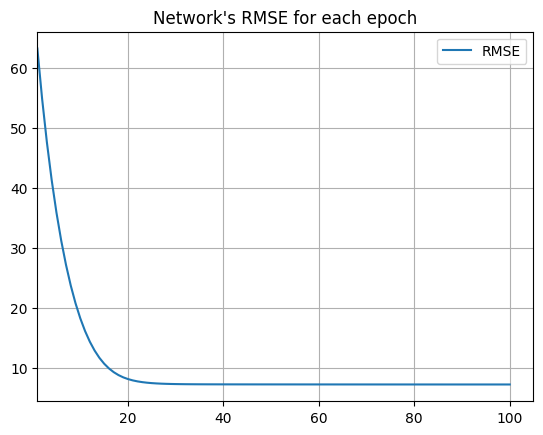

In [251]:
plt.title("Network's RMSE for each epoch")

plt.plot([x+1 for x in range(epochs)], error_history_per_neuron, label="RMSE")

plt.xlim(left=1)

plt.grid()
plt.legend()
plt.show()

Let's check our RMSE with this trained model

In [252]:
y_test = model.predict(X_test)
root_mean_squared_error(y_test, t_test)

np.float64(3.5354868624925953)

But we still need to look for the best hyperparameters, so, let's validate our network and check the new RMSE

In [253]:
better_err_hist,\
validation_error_per_neuron,\
error_history_per_neuron = model.validate(X_train, t_train, X_validation, t_validation, 100)

In [254]:
# Checking the new RMSE
y_test = model.predict(X_test)
root_mean_squared_error(y_test, t_test)

np.float64(3.589025676938982)

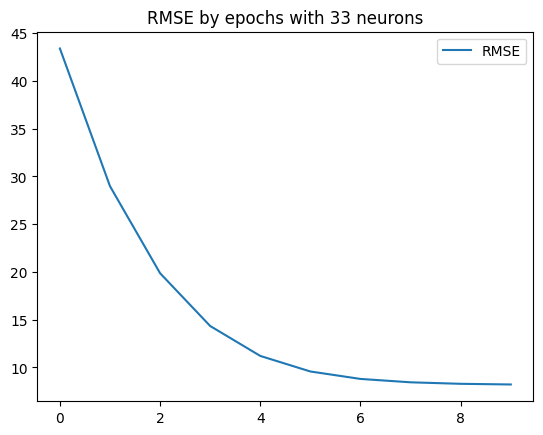

In [255]:
plt.title(f"RMSE by epochs with {model.dim_hidden} neurons")
plt.plot([epoch for epoch in range(len(better_err_hist))], better_err_hist, label="RMSE")
plt.legend()
plt.show()

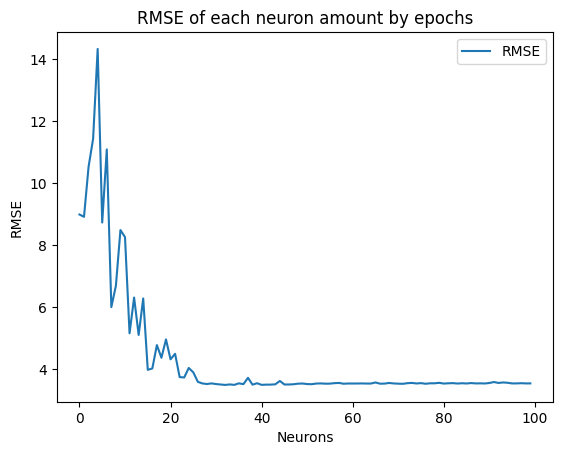

In [256]:
plt.title(f"RMSE of each neuron amount by epochs")

plt.plot([epoch for epoch in range(len(validation_error_per_neuron))], validation_error_per_neuron, label=f"RMSE")

plt.ylabel("RMSE")
plt.xlabel("Neurons")

plt.legend()
plt.show()

## Part II 

For this exercise you will build and train a 2-layer neural network that predicts the exact digit from a hand-written image, using the MNIST dataset. 
For this exercise, add weight decay to your network.

In [257]:
from sklearn.datasets import load_digits

In [258]:
digits = load_digits()

In [259]:
X = digits.data
t = digits.target

In [260]:
X.shape

(1797, 64)

In [261]:
# Transforming T to a one-hot matrix type
t_one_hot = np.eye(10)[t]

Again, you will split the data into training, validation and testing.

In [262]:
X_train, X_to_split, t_train, t_to_split = train_test_split(X, t_one_hot, train_size=.7)
X_validation, X_test, t_validation, t_test = train_test_split(X_to_split, t_to_split, train_size=.5)

In [263]:
def soft_max(a_k: np.ndarray) -> np.ndarray:
    # a_k shape = (n_samples, n_classes)
    exp_values = np.exp(a_k - np.max(a_k, axis=1, keepdims=True))  # estabilidade numérica
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

In [264]:
def cross_entropy(y, t):
        return -(t * np.log(y+1e-10)).sum()

In [268]:
model = MultilayerPerceptron1Hidden(
    sigmoid,
    d_sigmoid,
    cross_entropy,
    X_train.shape[1],
    1,
    10,
    soft_max
)

better_err_hist,\
validation_error_per_neuron,\
error_history_per_neuron = model.validate(X_train, t_train, X_validation, t_validation, 15, 50, 5e-4, 3e-3)

In [269]:
def choose_class(X):
    return np.argmax(X, axis=1)

print(f"Precisão do modelo no conjunto de treino: {(choose_class(model.predict(X_train)) == choose_class(t_train)).mean()}")
print(f"Precisão do modelo no conjunto de teste: {(choose_class(model.predict(X_test)) == choose_class(t_test)).mean()}")

print(choose_class(model.predict(X_train)))
print(choose_class(t_train))

Precisão do modelo no conjunto de treino: 0.18536197295147175
Precisão do modelo no conjunto de teste: 0.1925925925925926
[6 6 1 ... 6 5 6]
[3 3 0 ... 5 5 3]
